In [1]:
import os
import sys
import random
import warnings
import skimage.io
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import skimage.segmentation
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

/home/xiahe/.local/share/virtualenvs/nuclei-KirGtvdi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import tensorflow as tf

## Load Image

In [4]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'data/stage1_train/'
TEST_PATH = 'data/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [5]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [7]:
print(train_ids)

['16c3d5935ba94b720becc24b7a05741c26149e221e3401924080f41e2f891368', '0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe', '5b12df18e4ae4df5af06052584cf0e6bef58ee2a220653890636eef88a944e14', 'ae570a676961482848b5097038ef5e407df7a66a8e1c9b0567da599565a6b142', 'a1777737270c5f96c4523dff76e4097756f8f7d4c9d59bac079e31f9510deabd', 'f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3', '8055957570d7b38f0acecdb56f3078a963a1a7307ca03fcca62212e0e95e5845', '608ff81c8a0c8b622f6648a9c7f935d85f0c503f515ef2ac3728387be1953ee8', 'dbbfe08a52688d0ac8de9161cbb17cb201e3991aacab8ab8a77fe0e203a69481', '1f0008060150b5b93084ae2e4dabd160ab80a95ce8071a321b80ec4e33b58aca', '0b0d577159f0d6c266f360f7b8dfde46e16fa665138bf577ec3c6f9c70c0cd1e', 'b3bfd873fca7ff9b2e90f507dfdbe165bb8c153399b6ba5829aa59bae677a91d', '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426', 'c0152b1a260e71f9823d17f4fbb4bf7020d5dce62b4a12b3099c1c8e52a1c43a', '74a7785530687a11ecd073e772f90912d9967d02407a19

In [9]:
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [10]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [02:05<00:00,  5.33it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 59.09it/s]

Done!


/home/xiahe/.local/share/virtualenvs/nuclei-KirGtvdi/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/xiahe/.local/share/virtualenvs/nuclei-KirGtvdi/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


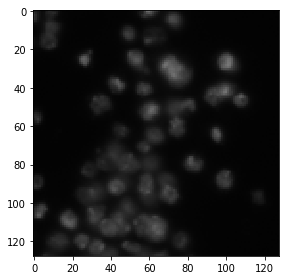

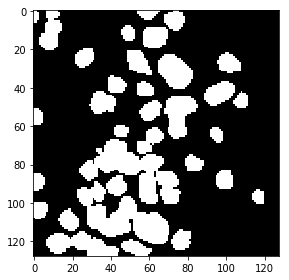

In [8]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [1]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Build U-Net model
# Don't use
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

In [10]:
# Build U-Net model
# USE ME!!!
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(64, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(64, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(128, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(128, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(256, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(256, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(512, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(512, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(512, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(512, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(256, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(256, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(128, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(128, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(64, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(64, (3, 3), activation='relu', padding='same') (c9)
c9 = Conv2D(2, 3, activation = 'relu', padding = 'same')(c9)
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [11]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=150, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/150
603/603 [==============================] - 840s 1s/step - loss: 0.4417 - mean_iou: 0.4151 - val_loss: 0.3046 - val_mean_iou: 0.4234

Epoch 00001: val_loss improved from inf to 0.30463, saving model to model-dsbowl2018-1.h5
Epoch 2/150
603/603 [==============================] - 831s 1s/step - loss: 0.2661 - mean_iou: 0.4244 - val_loss: 0.2427 - val_mean_iou: 0.4342

Epoch 00002: val_loss improved from 0.30463 to 0.24269, saving model to model-dsbowl2018-1.h5
Epoch 3/150
603/603 [==============================] - 830s 1s/step - loss: 0.1745 - mean_iou: 0.4795 - val_loss: 0.1397 - val_mean_iou: 0.5218

Epoch 00003: val_loss improved from 0.24269 to 0.13974, saving model to model-dsbowl2018-1.h5
Epoch 4/150
603/603 [==============================] - 829s 1s/step - loss: 0.1494 - mean_iou: 0.5446 - val_loss: 0.1068 - val_mean_iou: 0.5731

Epoch 00004: val_loss improved from 0.13974 to 0.10680, saving model to model-dsbowl2018-1.h5
Epo

In [11]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 29s 451ms/step


/home/xiahe/.local/share/virtualenvs/nuclei-KirGtvdi/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/xiahe/.local/share/virtualenvs/nuclei-KirGtvdi/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


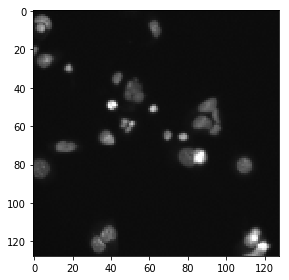

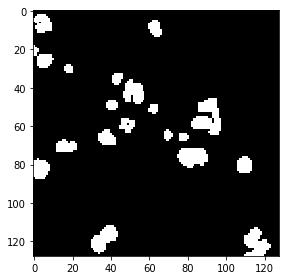

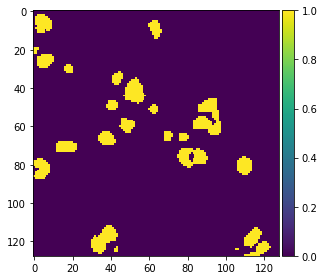

In [12]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [17]:
np.squeeze(Y_train[ix])
np.squeeze(preds_train_t[ix])
#mean_iou(np.squeeze(Y_train[ix]), np.squeeze(preds_train_t[ix]))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [18]:
preds_test[0]

array([[[0.11779655],
        [0.07938666],
        [0.05321372],
        ...,
        [0.02179919],
        [0.03365798],
        [0.12074615]],

       [[0.0254249 ],
        [0.01047374],
        [0.01228656],
        ...,
        [0.00267139],
        [0.00552026],
        [0.0455978 ]],

       [[0.01616383],
        [0.0091884 ],
        [0.01830617],
        ...,
        [0.004738  ],
        [0.00772809],
        [0.05098044]],

       ...,

       [[0.03571025],
        [0.01974757],
        [0.02100073],
        ...,
        [0.4275234 ],
        [0.17720811],
        [0.17397016]],

       [[0.02669751],
        [0.0104713 ],
        [0.01926866],
        ...,
        [0.2163239 ],
        [0.12617946],
        [0.1648843 ]],

       [[0.06227607],
        [0.03584594],
        [0.06043574],
        ...,
        [0.24465759],
        [0.19627973],
        [0.29341224]]], dtype=float32)

In [19]:
Y_test[0]

NameError: name 'Y_test' is not defined